# Imports

In [62]:
import gurobipy as gp
from gurobipy import GRB
import random
seed = 18
random.seed(seed)

## Create Model

In [63]:
model = gp.Model("Two-Stage Stochastic Programming Model for Vessel chartering strategies for Offshore Wind Farms")

# First-Stage Model

In [ ]:
# Sets
V = ["Crew Transfer Vessel", "Service Operation Vessel"]
T = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

Day_rate = { 
    "Crew Transfer Vessel": 2940, # Daily charter cost of Crew Transfer Vessel 
    "Service Operation Vessel": 11765, # Daily charter cost of Service Operation Vessel 
}

Mobilization_rate = { 
    "Crew Transfer Vessel": 58825, # Mobilization cost for Crew Transfer Vessel 
    "Service Operation Vessel": 235295, # Mobilization cost for Service Operation Vessel 
}

days = 30 # Number of days in a month

C_ST = { 
    (v, t): Day_rate[v] * days + Mobilization_rate[v] for v in V for t in T
}

C_LT = {
    (v): Day_rate[v] * days * len(T) + Mobilization_rate[v] for v in V
}

# Variables
gamma_ST = model.addVars(V, T, vtype=GRB.INTEGER, name="gamma_ST")
gamma_LT = model.addVars(V, vtype=GRB.INTEGER, name="gamma_LT")

# Second-Stage Model

## Second-Stage Sets, Parameters and Variables

In [65]:
# Sets
W = ["Wind Farm A", "Wind Farm B"]
M = ["Small Maintenance", "Large Maintenance"]
K_v = { 
    "Crew Transfer Vessel": [0],
    "Service Operation Vessel": [0, 1, 2]
}
D = [d for d in range(len(T) * days)] # days in planning horizon
D_t = {month: D[i * days : (i + 1) * days] for i, month in enumerate(T)} # days in each month

S = range(4) # scenarios

# Parameters

P_mk = { 
    "Small Maintenance": [4, 2, 0],
    "Large Maintenance": [0, 1, 2]
}
L_k = {
    0: 4,
    1: 5,
    2: 4
}
L_vw = {
    ("Crew Transfer Vessel", "Wind Farm A"): 2,
    ("Crew Transfer Vessel", "Wind Farm B"): 3,
    ("Service Operation Vessel", "Wind Farm A"): 4,
    ("Service Operation Vessel", "Wind Farm B"): 5
}

# Weather window
# Minimum length of weather window (in hours) 
from weather_generation_copy import gen_weather_seasonal, operability_tensor, daily_weather_windows, pack_windows_to_dict
min_window = 5

weather_limits = {
    "Crew Transfer Vessel": {"max_wind": 25.0, "max_wave": 1.5},
    "Service Operation Vessel": {"max_wind": 30.0, "max_wave": 2.0},
    }

#duration (in hours) of longest weather window in scenario s on day d, 0 if too short
wind, wave = gen_weather_seasonal(W, S, D, hours_per_day=24, seed=18) #create wind and wave arrays: [W, S, D, H]
# print(f"wind: {wind}")
# print(f"wave: {wave}")
vessels, op = operability_tensor(wind, wave, weather_limits) #convert wind and wave to operability tensor for each vessel [V, W, S, D, H]
# print(f"operability tensor: {op}")
Wwin = daily_weather_windows(op, min_window, vessels)  #[V, WF, S, D] #convert operability to longest daily weather windows per vessel per day [V, W, S, D]
# print(f"daily weather windows: {Wwin}")
A_vwd_s = pack_windows_to_dict(vessels, W, D, S, Wwin) #pack longest daily weather windows to dict A_vwd_s[(v, w, d, s)] = hours
print(f"A_vwd_s: {A_vwd_s}")

# Teams on each vessel type
N_v = {
    "Crew Transfer Vessel": 2,
    "Service Operation Vessel": 14
}

# initial backlog of maintenance tasks of category m at wind farm w
B_mw_0 = 0
# number of failures of maintenance tasks of category m that occurs at wind farm w in scenario s on day d
F_mwd_s = {}

for m in M:
    for w in W:
        for d in D:
            for s in S:
                if m == "Small Maintenance":
                    F_mwd_s[(m, w, d, s)] = random.randint(0, 10)  # Simulerer 0-2 små vedlikeholdsoppgaver
                else:
                    F_mwd_s[(m, w, d, s)] = random.randint(0, 2)  # Simulerer 0-1 store vedlikeholdsoppgaver

# Variables
x = model.addVars(V, W, D, S, vtype=GRB.INTEGER, name="x")
l = model.addVars(
    ((v, w, d, k, s) 
    for v in V
    for w in W
    for d in D
    for k in K_v[v]
    for s in S),
    vtype=GRB.INTEGER, 
    name="lambda"
)
z = model.addVars(W, M, D, S,  vtype=GRB.INTEGER, name="z")
b = model.addVars(W, M, D, S, vtype=GRB.INTEGER, name="b")

C_D = {key: 9100 for key in b.keys()}
C_U = {key: 2 for key in x.keys()}

A_vwd_s: {('Crew Transfer Vessel', 'Wind Farm A', 0, 0): 10, ('Crew Transfer Vessel', 'Wind Farm A', 1, 0): 6, ('Crew Transfer Vessel', 'Wind Farm A', 2, 0): 23, ('Crew Transfer Vessel', 'Wind Farm A', 3, 0): 24, ('Crew Transfer Vessel', 'Wind Farm A', 4, 0): 24, ('Crew Transfer Vessel', 'Wind Farm A', 5, 0): 24, ('Crew Transfer Vessel', 'Wind Farm A', 6, 0): 24, ('Crew Transfer Vessel', 'Wind Farm A', 7, 0): 17, ('Crew Transfer Vessel', 'Wind Farm A', 8, 0): 24, ('Crew Transfer Vessel', 'Wind Farm A', 9, 0): 6, ('Crew Transfer Vessel', 'Wind Farm A', 10, 0): 7, ('Crew Transfer Vessel', 'Wind Farm A', 11, 0): 24, ('Crew Transfer Vessel', 'Wind Farm A', 12, 0): 24, ('Crew Transfer Vessel', 'Wind Farm A', 13, 0): 5, ('Crew Transfer Vessel', 'Wind Farm A', 14, 0): 6, ('Crew Transfer Vessel', 'Wind Farm A', 15, 0): 24, ('Crew Transfer Vessel', 'Wind Farm A', 16, 0): 0, ('Crew Transfer Vessel', 'Wind Farm A', 17, 0): 0, ('Crew Transfer Vessel', 'Wind Farm A', 18, 0): 7, ('Crew Transfer Vess

## Objective Function

In [66]:
first_stage_obj = gamma_ST.prod(C_ST) + gamma_LT.prod(C_LT)

expected_second_stage_obj = (1 / len(S)) * (b.prod(C_D) + x.prod(C_U))

model.setObjective(first_stage_obj + expected_second_stage_obj)

print(f"first_stage_obj: {first_stage_obj}")
print(f"expected_second_stage_obj: {expected_second_stage_obj}")

first_stage_obj: 147025.0 <gurobi.Var *Awaiting Model Update*> + 147025.0 <gurobi.Var *Awaiting Model Update*> + 147025.0 <gurobi.Var *Awaiting Model Update*> + 147025.0 <gurobi.Var *Awaiting Model Update*> + 147025.0 <gurobi.Var *Awaiting Model Update*> + 147025.0 <gurobi.Var *Awaiting Model Update*> + 147025.0 <gurobi.Var *Awaiting Model Update*> + 147025.0 <gurobi.Var *Awaiting Model Update*> + 147025.0 <gurobi.Var *Awaiting Model Update*> + 147025.0 <gurobi.Var *Awaiting Model Update*> + 147025.0 <gurobi.Var *Awaiting Model Update*> + 147025.0 <gurobi.Var *Awaiting Model Update*> + 588245.0 <gurobi.Var *Awaiting Model Update*> + 588245.0 <gurobi.Var *Awaiting Model Update*> + 588245.0 <gurobi.Var *Awaiting Model Update*> + 588245.0 <gurobi.Var *Awaiting Model Update*> + 588245.0 <gurobi.Var *Awaiting Model Update*> + 588245.0 <gurobi.Var *Awaiting Model Update*> + 588245.0 <gurobi.Var *Awaiting Model Update*> + 588245.0 <gurobi.Var *Awaiting Model Update*> + 588245.0 <gurobi.Var *A

## Second-Stage Constraints

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 31680 rows, 28826 columns and 77567 nonzeros
Model fingerprint: 0xfe91205e
Variable types: 0 continuous, 28826 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [5e-01, 4e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 5.042365e+08
Presolve removed 16468 rows and 5923 columns
Presolve time: 0.10s
Presolved: 15212 rows, 22903 columns, 53908 nonzeros
Found heuristic solution: objective 5.042365e+08
Variable types: 0 continuous, 22903 integer (40 binary)
Found heuristic solution: objective 5.042365e+08

Root relaxation: objective 4.850856e+06, 10466 iterations, 0.07 seconds (0.04 work units)

    Nodes    |    

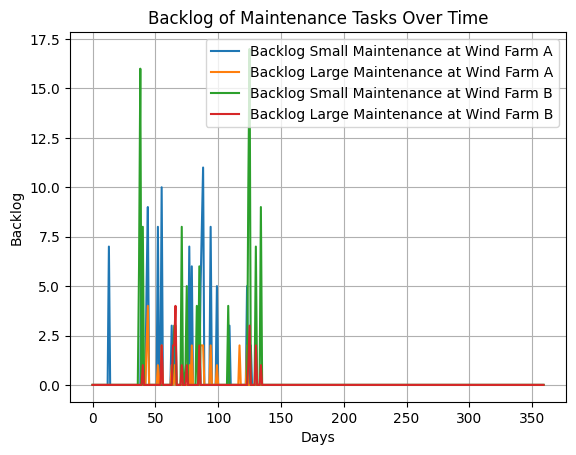

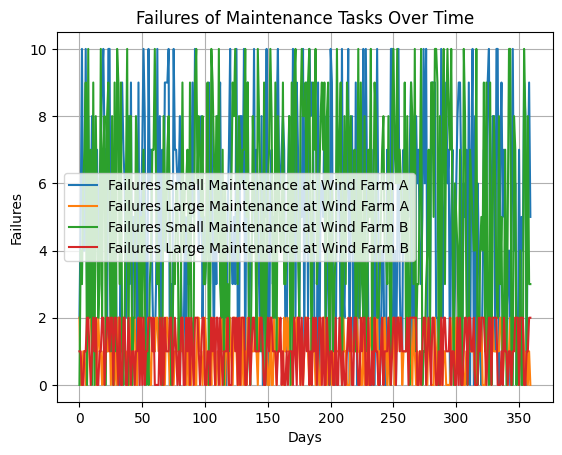

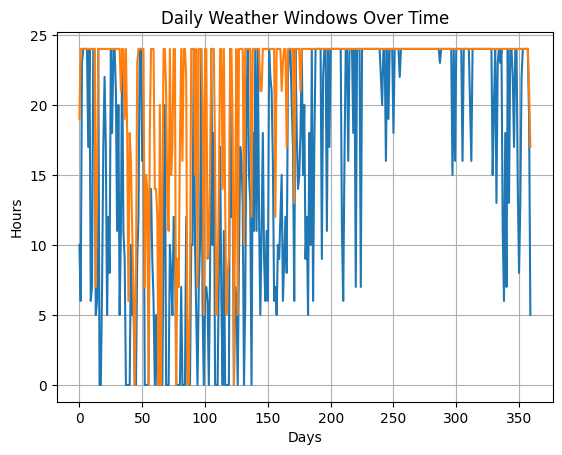

In [67]:
# The number of vessels allocated in the second stage cannot 
# exceed the number of vessels chartered in the first stage
model.addConstrs(
    (x.sum(v, '*', d, s) <= gamma_ST[v, t] + gamma_LT[v] 
    for v in V 
    for t in T 
    for d in D_t[t] 
    for s in S),
    name="vessels_available"
)

model.addConstrs(
    l.sum(v, w, d, '*', s) <= N_v[v] * x[v, w, d, s]
    for v in V
    for w in W
    for d in D
    for s in S
)

model.addConstrs(
    (L_k[k] + L_vw[v, w] - A_vwd_s[v,w,d,s])*l[v,w,d,k,s] <=0
    for v in V
    for w in W
    for d in D
    for k in K_v[v]
    for s in S
)

#connect maintenance tasks performed to patterns chosen (9)
for w in W:
    for m in M:
        for d in D:
            for s in S:
                model.addConstr(
                    z[w, m, d, s] <= gp.quicksum(P_mk[m][k] * l[v, w, d, k, s] for v in V for k in K_v[v]),
                    name=f"Maintenance_Task_Completion_m{m}_w{w}_d{d}_s{s}"
                )

model.addConstrs(
    b[w,m,0,s] == B_mw_0 
    for w in W 
    for m in M 
    for s in S
)

model.addConstrs(
    b[w,m,d,s] == b[w,m,d-1,s] + F_mwd_s[m,w,d,s] - z[w,m,d,s]
    for w in W
    for m in M
    for d in D[1:]
    for s in S
)

model.optimize()

for v in V:
    for t in T:
        if gamma_ST[v, t].X > 0:
            print(f"Short-term charter {gamma_ST[v, t].X} vessels of type {v} in month {t}")
for v in V:
    if gamma_LT[v].X > 0:
        print(f"Long-term charter {gamma_LT[v].X} vessels of type {v}")
        
print(f"Optimal objective value: {model.ObjVal}")

#print backlog for verification
for w in W:
    for m in M:
        backlog = [b[w, m, d, 0].X for d in D]
        print(f"Backlog of {m} at {w} over time: {backlog}")

#print usage of vessels for verification
for v in V:
    usage = [x[v, "Wind Farm A", d, 0].X for d in D]
    print(f"Usage of {v} over time: {usage}")

#plot backlog for each maintenance type at each wind farm over the planning horizon
import matplotlib.pyplot as plt
for w in W:
    for m in M:
        backlog = [b[w, m, d, 0].X for d in D]
        plt.plot(D, backlog, label=f'Backlog {m} at {w}')
plt.xlabel('Days')
plt.ylabel('Backlog')
plt.title('Backlog of Maintenance Tasks Over Time')
plt.legend()
plt.grid()
plt.show()

#plot failures for each maintenance type at each wind farm over the planning horizon
for w in W:
    for m in M:
        failures = [F_mwd_s[m, w, d, 0] for d in D]
        plt.plot(D, failures, label=f'Failures {m} at {w}')
plt.xlabel('Days')
plt.ylabel('Failures')
plt.title('Failures of Maintenance Tasks Over Time')
plt.legend()
plt.grid()
plt.show()

#plot resource windows for each vessel type over the planning horizon
for v in V:
    windows = [A_vwd_s[v, "Wind Farm A", d, 0] for d in D]
    plt.plot(D, windows, label=f'Weather Windows for {v}')
plt.xlabel('Days')
plt.ylabel('Hours')
plt.title('Daily Weather Windows Over Time')
plt.grid()
plt.show()